In [2]:
import numpy as np
import scipy.special
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Circle
from matplotlib.legend import _get_legend_handles_labels
from IPython.display import display, clear_output
from sympy import *
from sympy.utilities.lambdify import lambdify
from tqdm import tqdm
from time import sleep

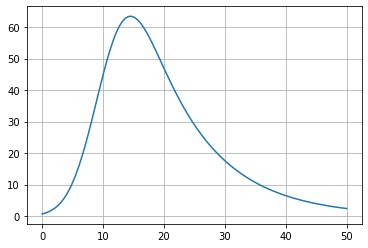

In [3]:
# Infectivity func

a, l, m, s, x = symbols("a, l, m, s, x")
infectivity_form = (a*l)/2*exp(l/2*(2*m+l*s**2-2*x))*(1-erf((m+l*s**2-x)/(sqrt(2)*s)))
infectivity_params = [(a, 1200), (l, .1), (m, 10), (s, 4)]
infectivity_func = lambdify(x, infectivity_form.subs(infectivity_params), modules=['numpy', {'erf': scipy.special.erf}])

x_range = np.linspace(0,50,100)
plt.plot(x_range, infectivity_func(x_range))
plt.grid()
plt.show()

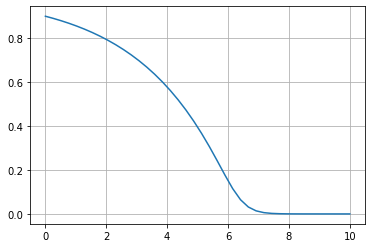

In [4]:
# Distance func

A, K, Q, B, v, d = symbols('A, K, Q, B, v, d')
distance_prob = -A+K-(K-A)*(Q*exp(-B*d)+1)**(-1/v)
distance_params = [(A, -.001), (K, 1), (v, 10), (B, 3.6), (Q, 1e10)]
distance_func = lambdify(d, distance_prob.subs(distance_params), "numpy")

x_range = np.linspace(0,10,40)
plt.plot(x_range, distance_func(x_range))
plt.grid()
plt.show()

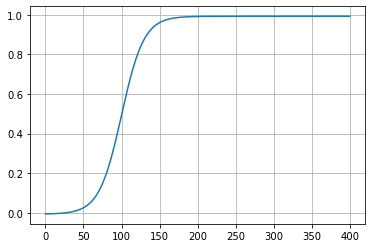

In [5]:
# Probability based on exposure

k, s, x = symbols('k, s, x')
exposure_prob = 1/(1+exp(-k*(x-s)))
exposure_params = [(k, .068), (s, 100)]
exposure_func = lambdify(x, exposure_prob.subs(exposure_params)-.007, "numpy")

x_range = np.linspace(0,400,1000)
plt.plot(x_range, exposure_func(x_range))
plt.grid()
plt.show()

In [26]:
class Person:
    def __init__(self, environment, location, group, speed, exposure_decrement):
        self.environment = environment
        self.location = location
        self.angle = np.random.uniform(0, 2*np.pi)
        self.angle_deviation = .5
        self.speed = speed
        self.group = group # "I", "S", "R"

        self.exposure = 0
        self.exposure_decrement = exposure_decrement
        self.caught_time = None
        self.recovered_time = None
        
    def move(self):
        self.angle += np.random.uniform(-self.angle_deviation,self.angle_deviation)
        vector = self.speed*np.array([np.cos(self.angle), np.sin(self.angle)])
        self.location = np.mod(self.location+vector, self.environment.shape)
        
    def decr_exposure(self):
        self.exposure = max(self.exposure-self.exposure_decrement, 0)
        
class Environment:
    def __init__(self, infectivity_func, distance_func, exposure_func, shape=np.array([100,100]), radius=8, recovery_time=60, speed=1, exposure_decrement=10,immunity_time = 60):
        self.shape = shape
        
        self.radius = radius
        self.infectivity_func = infectivity_func
        self.distance_func = distance_func
        self.exposure_func = exposure_func
        self.recovery_time = recovery_time
        self.immunity_time = immunity_time
        self.people = {"S": [],
                      "I": [],
                      "R": []}
        self.speed = speed
        self.exposure_decrement = exposure_decrement
        
        self.time = 0
        
    def add_person(self, group="S"):
        person = Person(self, np.random.uniform(self.shape), group, self.speed, self.exposure_decrement)
        self.people[group].append(person)
        if group == "I":
            person.caught_time = 0
            
    def move_all(self):
        for group in self.people.values():
            for person in group:
                person.move()
        
    def advance_time(self):
        self.time += 1
        self.move_all()
        
        idx = len(self.people["R"])-1
        while idx>= 0:
            recovered = self.people["R"][idx]
            if self.time > recovered.recovered_time+self.immunity_time:
                del self.people["R"][idx]
                self.people["S"].append(recovered)
                recovered.group = "S"
                recovered.exposure = 0
            idx -= 1
        
        idx = len(self.people["I"])-1
        while idx >= 0:
            infected = self.people["I"][idx]
            if self.time > infected.caught_time+self.recovery_time:
                del self.people["I"][idx]
                self.people["R"].append(infected)
                infected.group = "R"
                infected.recovered_time = self.time
            else:
                for person in self.people["S"]:
                    vector = np.abs(person.location - infected.location)
                    wrapped_vector = np.minimum(vector, self.shape-vector)
                    distance = np.linalg.norm(wrapped_vector, ord=2)
                    if distance <= self.radius:
                        person.exposure += self.infectivity_func(self.time - infected.caught_time)*self.distance_func(distance)
            idx -= 1
    
        idx = len(self.people["S"])-1
        while idx >= 0:
            susceptible = self.people["S"][idx]
            if np.random.random() < self.exposure_func(susceptible.exposure):
                del self.people["S"][idx]
                self.people["I"].append(susceptible)
                susceptible.group = "I"
                susceptible.caught_time = self.time
            else:
                susceptible.decr_exposure()
            idx -= 1

        return [np.array([person.location for person in group]) for group in self.people.values()]

In [27]:
# Rerun this cell before every simulation (this generates the environment and adds the people)

env = Environment(infectivity_func, distance_func, exposure_func, speed=1, exposure_decrement=15)

for _ in range(199):
    env.add_person()
    
env.add_person("I")

KeyboardInterrupt: 

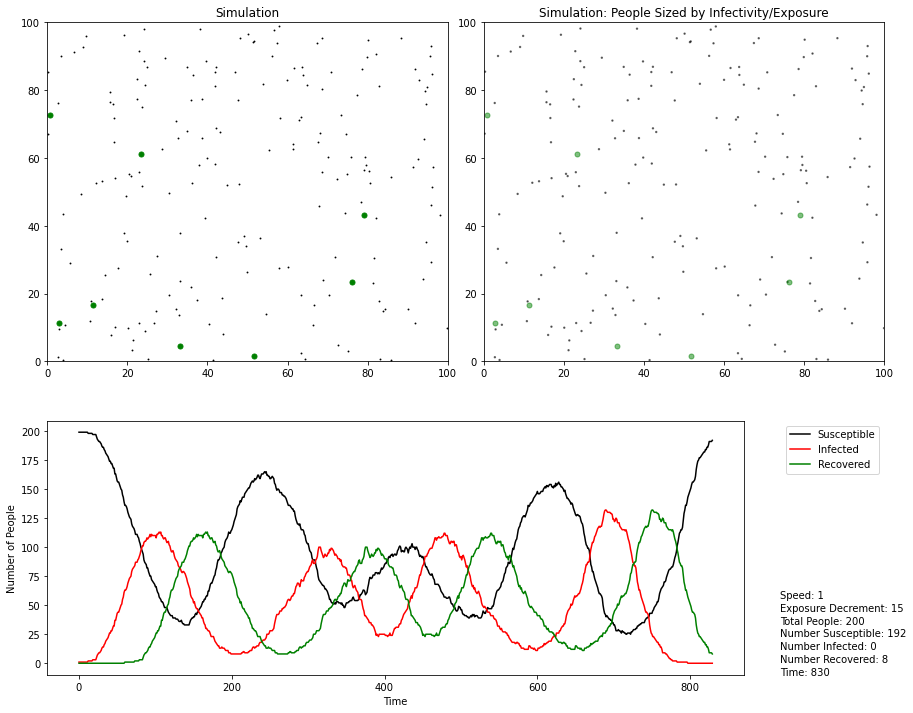

In [28]:
# This cell has one graph for all of the lines
# To save frames, add a folder in the same directory called output
# Otherwise, comment out the savefig line

fig = plt.figure(figsize=(15,12))
gs = GridSpec(2,4, figure=fig, height_ratios=[4,3], width_ratios=[5,2,5,2])
ax_sim1 = fig.add_subplot(gs[0,:2])
ax_sim1.set_xlim(0,env.shape[0])
ax_sim1.set_ylim(0,env.shape[1])

ax_sim2 = fig.add_subplot(gs[0,2:])
ax_sim2.set_xlim(0,env.shape[0])
ax_sim2.set_ylim(0,env.shape[1])

ax_infected = fig.add_subplot(gs[1,:-1])
ax_info = fig.add_subplot(gs[1,-1])

num_s = []
num_i = []
num_r = []

while True:
    S_locs, I_locs, R_locs = env.advance_time()
    if not S_locs.size:
        S_locs = np.empty(shape=(0,2))
    if not I_locs.size:
        I_locs = np.empty(shape=(0,2))
    if not R_locs.size:
        R_locs = np.empty(shape=(0,2))
    
    S_plot1 = ax_sim1.scatter(*S_locs.T, c="k", marker=".", s=3)
    R_plot1 = ax_sim1.scatter(*R_locs.T, c="g", marker=".", s=100)
    I_plot1 = ax_sim1.scatter(*I_locs.T, marker=".", s=100, c="r")

    ax_sim1.set_title("Simulation")
    
    I_size = np.array([env.infectivity_func(env.time - person.caught_time) for person in env.people["I"]])
    S_size = np.array([person.exposure for person in env.people["S"]])+2
    S_plot2 = ax_sim2.scatter(*S_locs.T, c="k", marker=".", s=S_size*4, alpha=.5)
    R_plot2 = ax_sim2.scatter(*R_locs.T, c="g", marker=".", s=100, alpha=.5)
    I_plot2 = ax_sim2.scatter(*I_locs.T, marker=".", s=I_size*20, c="r", alpha=.5)
    
    ax_sim2.set_title("Simulation: People Sized by Infectivity/Exposure")
    
    num_s.append(len(env.people["S"]))
    num_i.append(len(env.people["I"]))
    num_r.append(len(env.people["R"]))
    
    ax_infected.plot(num_s, color="k", label="Susceptible")
    ax_infected.plot(num_i, color="r", label="Infected")
    ax_infected.plot(num_r, color="g", label="Recovered")
    
    ax_infected.set_xlabel("Time")
    ax_infected.set_ylabel("Number of People")
    
    ax_info.legend(*ax_infected.get_legend_handles_labels())
    ax_info.axis('off')
    ax_info.text(0,0,"Time: "+str(env.time),size=10)
    ax_info.text(0,.05,"Number Recovered: "+str(num_r[-1]),size=10)
    ax_info.text(0,.1,"Number Infected: "+str(num_i[-1]),size=10)
    ax_info.text(0,.15,"Number Susceptible: "+str(num_s[-1]),size=10)
    ax_info.text(0,.2,"Total People: "+str(num_s[-1]+num_i[-1]+num_r[-1]),size=10)
    ax_info.text(0,.25,"Exposure Decrement: "+str(env.exposure_decrement),size=10)
    ax_info.text(0,.3,"Speed: "+str(env.speed),size=10)

    clear_output(wait=True)
    display(fig)
    #plt.savefig("output/output"+str(env.time))
    I_plot1.remove()
    S_plot1.remove()
    R_plot1.remove()
    I_plot2.remove()
    S_plot2.remove()
    R_plot2.remove()
    ax_infected.cla()
    ax_info.cla()

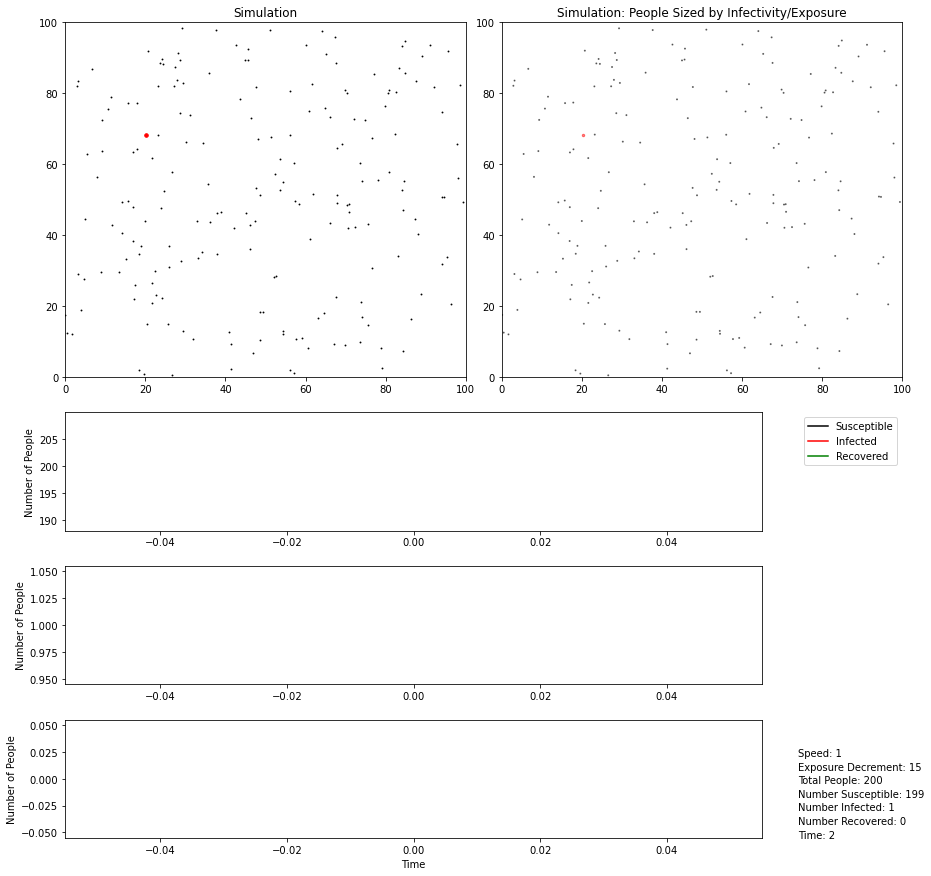

FileNotFoundError: [Errno 2] No such file or directory: 'output/output2.png'

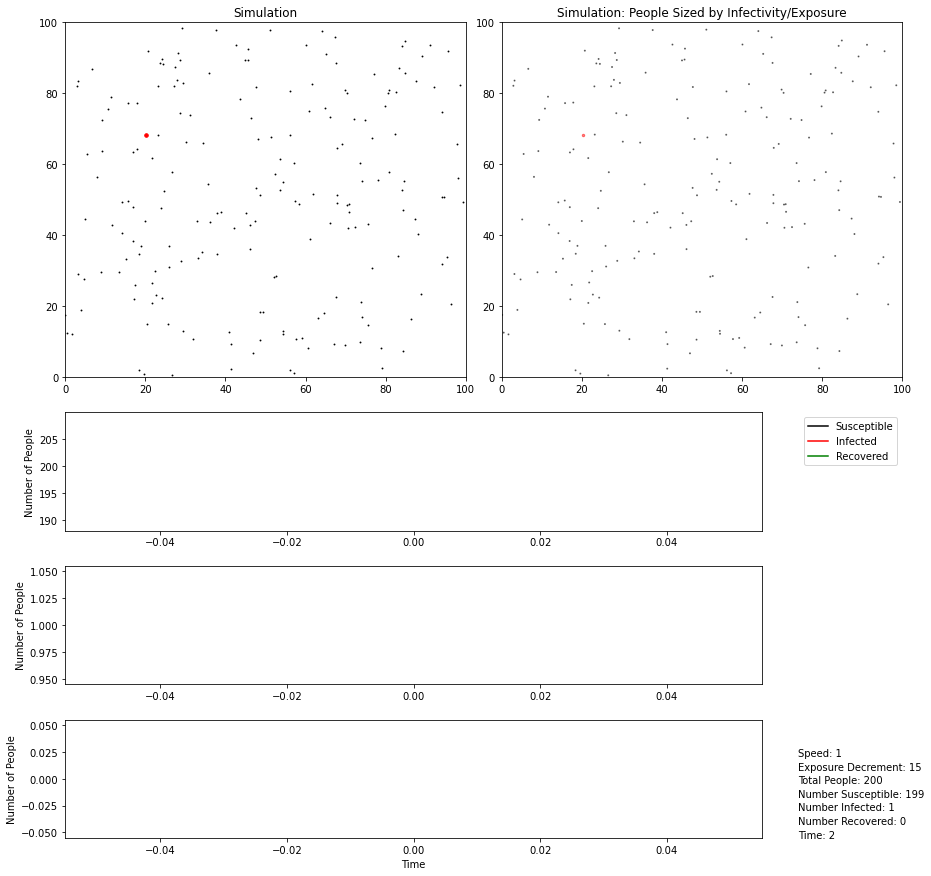

In [8]:
# This cell has separate graphs for each of the lines
# To save frames, add a folder in the same directory called output
# Otherwise, comment out the savefig line

fig = plt.figure(figsize=(15,15))
gs = GridSpec(4,4, figure=fig, height_ratios=[3,1,1,1], width_ratios=[5,2,5,2])
ax_sim1 = fig.add_subplot(gs[0,:2])
ax_sim1.set_xlim(0,env.shape[0])
ax_sim1.set_ylim(0,env.shape[1])

ax_sim2 = fig.add_subplot(gs[0,2:])
ax_sim2.set_xlim(0,env.shape[0])
ax_sim2.set_ylim(0,env.shape[1])

ax_susceptible = fig.add_subplot(gs[1,:-1])
ax_infected = fig.add_subplot(gs[2,:-1])
ax_recovered = fig.add_subplot(gs[3,:-1])
ax_legend = fig.add_subplot(gs[1,-1])
ax_info = fig.add_subplot(gs[2:,-1])

num_s = []
num_i = []
num_r = []

while True:
    S_locs, I_locs, R_locs = env.advance_time()
    if not S_locs.size:
        S_locs = np.empty(shape=(0,2))
    if not I_locs.size:
        I_locs = np.empty(shape=(0,2))
    if not R_locs.size:
        R_locs = np.empty(shape=(0,2))
    
    S_plot1 = ax_sim1.scatter(*S_locs.T, c="k", marker=".", s=3)
    R_plot1 = ax_sim1.scatter(*R_locs.T, c="g", marker=".", s=50)
    I_plot1 = ax_sim1.scatter(*I_locs.T, marker=".", s=50, c="r")

    ax_sim1.set_title("Simulation")
    
    I_size = np.array([env.infectivity_func(env.time - person.caught_time) for person in env.people["I"]])
    S_size = np.array([person.exposure for person in env.people["S"]])+2
    S_plot2 = ax_sim2.scatter(*S_locs.T, c="k", marker=".", s=S_size*2, alpha=.5)
    R_plot2 = ax_sim2.scatter(*R_locs.T, c="g", marker=".", s=50, alpha=.5)
    I_plot2 = ax_sim2.scatter(*I_locs.T, marker=".", s=I_size*10, c="r", alpha=.5)
    
    ax_sim2.set_title("Simulation: People Sized by Infectivity/Exposure")
    
    num_s.append(len(env.people["S"]))
    num_i.append(len(env.people["I"]))
    num_r.append(len(env.people["R"]))
    
    ax_susceptible.plot(num_s, color="k", label="Susceptible")
    ax_infected.plot(num_i, color="r", label="Infected")
    ax_recovered.plot(num_r, color="g", label="Recovered")
    
    ax_recovered.set_xlabel("Time")
    ax_susceptible.set_ylabel("Number of People")
    ax_infected.set_ylabel("Number of People")
    ax_recovered.set_ylabel("Number of People")
    
    ax_legend.legend(*_get_legend_handles_labels([ax_susceptible, ax_infected, ax_recovered]))
    ax_legend.axis("off")
    ax_info.text(0,0,"Time: "+str(env.time),size=10)
    ax_info.text(0,.05,"Number Recovered: "+str(num_r[-1]),size=10)
    ax_info.text(0,.1,"Number Infected: "+str(num_i[-1]),size=10)
    ax_info.text(0,.15,"Number Susceptible: "+str(num_s[-1]),size=10)
    ax_info.text(0,.2,"Total People: "+str(num_s[-1]+num_i[-1]+num_r[-1]),size=10)
    ax_info.text(0,.25,"Exposure Decrement: "+str(env.exposure_decrement),size=10)
    ax_info.text(0,.3,"Speed: "+str(env.speed),size=10)
    ax_info.axis('off')

    clear_output(wait=True)
    display(fig)
    plt.savefig("output/output"+str(env.time))
    I_plot1.remove()
    S_plot1.remove()
    R_plot1.remove()
    I_plot2.remove()
    S_plot2.remove()
    R_plot2.remove()
    ax_susceptible.cla()
    ax_infected.cla()
    ax_recovered.cla()
    ax_legend.cla()
    ax_info.cla()